In [2]:
from surface_dynamics.all import Origami
import numpy as np

# Step 1: Drew's Function and $SL_2\mathbb{Z}$ Action

In [3]:
# The matrices S, S^(-1), and R generate the group SL2Z
S = Matrix(ZZ, [[1,1],[0,1]])
R = Matrix(ZZ,[[0,-1],[1,0]])

# The SL2Z_Action function takes an origami ori and a 2x2 matrix A with integer coefficients as arguments
# It tests whether A is an element of SL2Z, and if so it returns the image of ori under the action of A
# If A is not an element of SL2Z, it returns an error message
def SL2Z_Action(ori, A):
    
    # Tests whether A is in SL2Z
    if det(A) != 1:
        return "Error: The input matrix is not an element of SL2Z"
        
    # List that will hold generators that produce A when multiplied in the order they appear
    # Temporary matrix that we will update as we reduce A to the identity using generators
    generators = []
    A_temp = A
    
    # Reduce A_temp to the identity by multiplying on the left by S, S^(-1), and R repeatedly
    # Simultaneously add the inverse of the matrix that is being multiplied to the end of list of generators
    while A_temp[1][0] != 0:
        if abs(A_temp[0][0])>=abs(A_temp[1][0]):
            if sgn(A_temp[0][0]) == sgn(A_temp[1][0]):
                A_temp = S^(-1)*A_temp
                generators = generators + [S]
            else:
                A_temp = S*A_temp
                generators = generators + [S^(-1)]
        else:
            A_temp = R*A_temp
            generators = generators + [R,R,R]
    if A_temp[0][0] == 1:
        while A_temp[0][1] > 0:
            A_temp = S^(-1)*A_temp
            generators = generators + [S]
        while A_temp[0][1] < 0:
            A_temp = S*A_temp
            generators = generators + [S^(-1)]
    else:
        while A_temp[0][1] < 0:
            A_temp = S^(-1)*A_temp
            generators = generators + [S]
        while A_temp[0][1] > 0:
            A_temp = S*A_temp
            generators = generators + [S^(-1)]
        A_temp = R*R*A_temp
        generators = generators + [R,R]
    
    # Test to confirm that generators in list multiply to produce A
    # If not, return error message
    product = Matrix(ZZ,[[1,0],[0,1]])
    for generator in generators:
        product = product*generator
    if product != A:
        return "Error: Decomposition into product of generators has failed"
        
    # Origami that will be returned after the action of A is applied
    A_times_ori = ori
    
    # Apply generators in list in reverse order because A is multiplied on the left of ori
    for generator in reversed(generators):
        if generator == R:
            A_times_ori = A_times_ori.horizontal_symmetry().mirror()
            # print('R')
        elif generator == S:
            A_times_ori = A_times_ori.horizontal_twist(1)
            # print('S')
        else:
            A_times_ori = A_times_ori.horizontal_twist(-1)
            # print('S_inv')
            
    return A_times_ori

In [4]:
# The find_Simple_Cylinder function takes as its input an origami ori_0. It searches the whole SL2Z orbit of ori_0
# for all horizontal simple cylinders. Every simple cylinder in ori_0 will be represented at least once in the output.
# It returns a list of tuples, where each tuple is of the form
# (A^(-1),ori,cyl_rows,height,width,twist,bot_sing,top_sing), where:
# * A^(-1) is the matrix in SL2Z that maps ori_0 to the origami where this simple cylinder was found
# * ori is the output of the action of A^(-1) on ori_0
# * cyl_rows is a list of tuples, where each tuple represents a row of the simple cylinder and the rows are stacked in the order
# they appear in the list, with the first row in the list at the bottom of the corresponding simple cylinder
# * height is the height of the simple cylinder
# * width is the width of the simple cylinder
# * twist of the horizontal distance (travelling to the right) from the bottom singularity to the top singularity
# * bot_sing is the square in the simple cylinder that has a singularity on its bottom right corner
# * top_sing is the square in the simple cylinder that has a singularity on its top right corner
def find_Simple_Cylinder(ori_0):
    simple_cylinders = []
    
    # Loops over the SL2Z orbit of ori_0
    for A in ori_0.veech_group().coset_reps():
        ori = SL2Z_Action(ori_0, A^(-1)) # Use A^(-1) because coset_reps() gives right coset reps
        cylinders = ori.r().cycle_tuples(singletons=True)
        
        # Loops over all horizontal cycles of ori
        for cylinder in cylinders:
            top_sings = [] # List of squares with singular points in their top right corner
            cyl_rows = [cylinder] # List of rows in the smallest cylinder containing starting row and at least one singularity on top and bottom
            while len(top_sings) == 0 and len(cyl_rows) < len(cylinders):
                for i in cyl_rows[-1]:
                    if ori.r()(ori.u()(i)) != ori.u()(ori.r()(i)):
                        top_sings.append(i) # Counts number of singularities above top row of cyl_rows
                
                if len(top_sings) == 0:
                    above_row = []
                    for i in cyl_rows[-1]:
                        above_row.append(ori.u()(i))
                    cyl_rows.append(tuple(above_row)) # Adds another row above if there are no singular points yet
            if len(top_sings) == 1:
                bot_sings = [] # List of squares with singular points in their bottom right corner
                while len(bot_sings) == 0 and len(cyl_rows) < len(cylinders):
                    for i in cyl_rows[0]:
                        if ori.r()(ori.u().inverse()(i)) != ori.u().inverse()(ori.r()(i)):
                            bot_sings.append(i) # Counts number of singularities below bottom row of cyl_rows
                            
                    if len(bot_sings) == 0:
                        below_row = []
                        for i in cyl_rows[0]:
                            below_row.append(ori.u().inverse()(i))
                        cyl_rows.insert(0,tuple(below_row)) # Adds another row below if there are no singular points yet
                
                # If there is exactly one singular point on bottom and top, creates cylinder tuple and adds it to list if not yet included
                if len(bot_sings) == 1:
                    top_sing = top_sings[0]
                    bot_sing = bot_sings[0]
                    height = len(cyl_rows)
                    width = len(cyl_rows[0])
                    twist = 0
                    bot_sing_im = bot_sing
                    for i in range(1,height):
                        bot_sing_im = ori.u()(bot_sing_im) # bot_sing_im is image of bottom singularity on the top row of the cylinder
                    while bot_sing_im != top_sing:
                        bot_sing_im = ori.r()(bot_sing_im)
                        twist = twist+1
                    cyl_info = (A^(-1),ori,cyl_rows,height,width,twist,bot_sing,top_sing)
                    
                    if cyl_info not in simple_cylinders:
                        simple_cylinders.append(cyl_info)
                        
    return simple_cylinders

# Steps 2-3: Brendan's Functions

In [ ]:
origami = Origami('(1,35,9,27,17,3,33,11,25,31)(2,4,30,16,14,12,10,24,22,8)(5,15)(6,36)(7,29)(13,23)(18,32)(19,21)(20,34)(26,28)',\
              '(1,16,27,10,33,8,31,30,9,12,3,22,21,28,7,18,5,20,23,6,25,4,35,14,17,24,19,26,29,32,15,34,13,36,11,2)')
origami.show()

In [ ]:
slope = [3/4,-1]
p = 22
simple_C = [(21, 19), (28, 26), (7, 29), (18, 32), (5, 15), (20, 34), (23, 13), (6, 36)]
all_singulariry = [6,10,22]

v2_slope_intersection(p, simple_C, origami, slope, all_singulariry)

In [5]:
def v2_slope_intersection(p, simple_C, origami, slope, all_singulariry):
    """
    Func:
    Take an origami, a horizontal simple cylinder simple_C, and a singular point p, 
    check whether an arrow from p follow the direction slope all intersect the 
    the top of simple_C without hitting other singularities

    Args:
    p: a singular point which is represented using the origami where a point lies on its 
                up-right corner; it's where arrows would come from.
    simple_C: ((c11,c12,...,c1n),
                (...),
               (cm1,cm2,...,cmn)), representing a simple cylinder of shape (m,n)
    origami: An Origami object of surface_dynamics
    slope: (x0,-1), a vector representing the direction of the arrow
    all_singulariry: the list of all sigularities in origami

    Return:
    result: A bool, True if all arrows intersect the top of simple_C, False otherwise.
    """
    up_per = origami.u().cycle_tuples()
    right_per = origami.r().cycle_tuples()
    
    ##############################################
    down_action = origami.u().inverse()
    right_action = origami.r()
    left_action = right_action.inverse()
    ##############################################
    
    horizontal_step = - QQ(slope[0]) / QQ(slope[1])
    # or horizontal_step = slope[0] if we make sure slope[1] = -1
    surf = simple_C[-1]
    
    # find the intersection ip of point p
    present_move = QQ(0) #rational number, always >= 0, since it record the distance 
                     #from the up-right corner of a square
    present_point = p
    path = [] # used to check whether a loop is formed
    ip = None # the intersection point at the top of the cylinder
    while(True):
        # move for one whole step, where we always go down for 1
        
        present_move += horizontal_step
        """
        for up in up_per:
            if present_point not in up:
                continue
            point_pos = up.index(present_point)
            present_point = up[(point_pos-1)%len(up)] # move up for one square
        """
        
        if present_move >= 1: # need to go right
            round_step = int(present_move)
            #print(round_step)
            present_move = present_move - round_step
            for right in right_per:
                if present_point not in right:
                    continue
                point_pos = right.index(present_point)
                present_point = right[(point_pos+round_step)%len(right)] # move right for some squares
        if present_move < 0: # need to go left
            round_step = - int(present_move) + 1
            present_move = round_step + present_move
            # boundary condition
            if present_move == 1:
                round_step -= 1
                present_move = 0
            for right in right_per:
                if present_point not in right:
                    continue
                point_pos = right.index(present_point)
                present_point = right[(point_pos-round_step)%len(right)] # move left for some squares

########################################################################
#         for up in up_per:
#             if present_point not in up:
#                 continue
#             point_pos = up.index(present_point)
#             present_point = up[(point_pos-1)%len(up)] # move up for one square

        if present_move > 0:
            present_point = left_action(down_action(right_action(present_point)))
        else:
            present_point = down_action(present_point)
########################################################################

        #print(present_point, present_move)
        # we also want to make sure no other singularity is reached
        if present_point in all_singulariry and present_move == 0:
            return [False]
        
        
        # check whether or not surf is reached
        if present_point in surf:
            ip = present_point
            ######################################
            path.append(present_point)
            ######################################
            break
        if present_point in path:
            
#             print("The flow of one point doesn't intersect with the surf, but forms a loop.")
#             print(p)
#             print(path)
            return [False]
        
        path.append(present_point)
    return [True,ip, present_move,len(path)]

def test_southward_arrows(mat_ori_cyls, num_squares):
    
    #print(len(mat_ori_cyls[1]))
    
    #ori_num  = 1
    returnlist = []
    for mat_ori_cyl in mat_ori_cyls:
        #print("ori_num: ", ori_num)
        ori = mat_ori_cyl[1]
        genus = ori.genus()
        cyl = mat_ori_cyl[2]
        twist = mat_ori_cyl[5]
        ####################################################
        h1 = mat_ori_cyl[3]
        width = mat_ori_cyl[4]
        ####################################################
        shear_matrix = Matrix(QQ,[[1,(-1*twist)/h1],[0,1]])
        #print(shear_matrix)
        n = 0
        int_shear_matrix = Matrix(QQ,[[1,n],[0,1]]) #initialize to indentity
        #print(int_shear_matrix in ori.veech_group()) 
        slopes = []
        singularities = []
        i = 1;
        while i<=num_squares: #find all the singularities
            if ori.r()(ori.u()(i)) != ori.u()(ori.r()(i)): #then we are at a singularity!
                singularities.insert(0,i)
            i = i + 1
        
        #print(singularities)
        
        in_veech = False
        while(in_veech == False):
            
            #print("n: ",n)
            composition_matrix =  int_shear_matrix * shear_matrix
            
            
#             print(composition_matrix)
#             print(int_shear_matrix)
#             print(shear_matrix)
            
            
            slope = [composition_matrix[0][1],-1]
            #print("slope: ",slope)
            arrows_found = [] 
            num_times_south_arrow_hit_cyl = 0
            num_south_arrows = 0
            
            found_3_arrows = False
            singularities_with__v2_output = []
           
            #while i<=num_squares and found_3_arrows == False:
            for i in singularities:
                if  found_3_arrows == True:
                    break
                #print("i: ",i)
                intersect_top_of_cylinder = False
                square_in_cyl = False;
               
                    #print("at a singl above ",i)
    
    
                    #squares_we_get_to_from_i = ori.u().inverse()(i)
                intersect_top_of_cylinder = False
                v2_output = v2_slope_intersection(i, cyl, ori, slope, singularities)
                #print([i], cyl, ori, slope, singularities)
                intersect_top_of_cylinder = v2_output[0]
                #print(intersect_top_of_cylinder)
                if  i not in arrows_found and intersect_top_of_cylinder == True: 
                    singularities_with__v2_output.append([i,v2_output])
                    num_times_south_arrow_hit_cyl = num_times_south_arrow_hit_cyl + 1   
                    arrows_found.insert(0,i)
                    #print(num_south_arrows)
                    num_south_arrows = num_south_arrows + 1;
                    #print(num_south_arrows)
                    if num_south_arrows == 2*genus - 2: 
                        #print("found 3 arrows!")
                        slopes.append([slope, singularities_with__v2_output])
                       
                        found_3_arrows = True
                        
                #print("arrows_found", arrows_found)
               
            n = QQ(n) + QQ(width/h1)
            int_shear_matrix = Matrix(QQ,[[1,n],[0,1]])
            if int_shear_matrix in ori.veech_group():
                in_veech = True
                #print("in VEECH")
             #print(n)
            #ori_num  = ori_num + 1
        #print([ori,cyl, singularities, slopes ])
        if len(slopes) > 0:
            returnlist.append([ori,cyl, singularities, slopes ])
    #print(num_times_south_arrow_hit_cyl)
    return returnlist

# Step 4: Siyi's Function

In [6]:
# the interval length is preserved is also checked
def interval_slope_return_map(up_points, simple_C, origami, slope):
    """
    Func:
    Take an origami, a horizontal simple cylinder simple_C, and the points on the top of simple_C
    intersected by the arrows of test step 3, check whether the first return map of the up_points
    is in reverse order on the bottom of simple_C

    Args:
    up_points: (p1,p2,p3,...,p_i) which is represented using the origami where a point lies on its 
                up-right corner. They could apear not in order, but the starting point doesn't matter.
                They are sigular points where arrows come from
    simple_C: ((c11,c12,...,c1n),
                (...),
               (cm1,cm2,...,cmn)), representing a simple cylinder of shape (m,n)
    origami: An Origami object of surface_dynamics
    slope: (x0,y0), a vector representing the direction of the return map, y0 > 0, while x0 might < 0

    Return:
    result: A bool, True if the first return map of the up_points is in reverse order on the bottom of 
    simple_C, False otherwise.
    """
    up_per = origami.u().cycle_tuples()
    #print(up_per)
    right_per = origami.r().cycle_tuples()
    #print(right_per)
    ##############################################
    up_action = origami.u()
    down_action = up_action.inverse()
    right_action = origami.r()
    left_action = right_action.inverse()
    ##############################################

    horizontal_step = slope[0] / slope[1] # can be a negative value, representing the horizontal
                                          # length needed to move when moving up for one step
    #print("horizontal_step", horizontal_step)
    bottom = simple_C[0]
#     print(bottom)
    down_points = []
    down_move = []
    
    #remove singularity on top of cylinder
    real_points = []
    for p in up_points:
        if p not in simple_C[-1]:
            real_points.append(p)
    up_points = real_points

    # construct the list of return maps
    for p in up_points:
        # find the return map rp of point p
        present_move = 0 #rational number, always >= 0, since it record the distance 
                         #from the up-right corner of a square
        present_point = p
        path = [] # used to check whether a loop is formed
        rp = None
        while(True):
            # move for one whole step, where we always go up for 1
            present_move += horizontal_step
            #print(present_move)
            
            if present_move >= 1: # need to go right
                round_step = int(present_move)
                #print(round_step)
                present_move = present_move - round_step
                for right in right_per:
                    if present_point not in right:
                        continue
                    point_pos = right.index(present_point)
                    #print("original singularity", p)
                    #print("previously", present_point)
                    present_point = right[(point_pos+round_step)%len(right)] # move right for some squares
                    #print("now", present_point)
            if present_move < 0: # need to go left
                round_step = - int(present_move) + 1
                present_move = round_step + present_move
                # boundary condition
                if present_move == 1:
                    round_step -= 1
                    present_move = 0
                for right in right_per:
                    if present_point not in right:
                        continue
                    point_pos = right.index(present_point)
                    present_point = right[(point_pos-round_step)%len(right)] # move left for some squares

########################################################################
                
#             for up in up_per:
#                 if present_point not in up:
#                     continue
#                 #print(up)
#                 point_pos = up.index(present_point)
#                 #print("before move up", present_point)
#                 present_point = up[(point_pos+1)%len(up)] # move up for one square
#                 #print("after move up", present_point)
            if present_move > 0:
                present_point = left_action(up_action(right_action(present_point)))
            else:
                present_point = up_action(present_point)

########################################################################

            # check whether or not bottom is reached
            if present_point in bottom:
                rp = present_point
                break
            if present_point in path:
#                 print("The return map of one point doesn't intersect with the bottom, but forms a loop.")
#                 print(p)
#                 print(path)
                return False
            path.append(present_point)
        # append rp
        down_points.append(rp)
        down_move.append(present_move)
        
    surf = simple_C[-1]
#     print(surf)
    surf_points = []
    surf_move = []
    # construct the list of intersection points onto the up edge of the cylinder
    for p in up_points:
        # find the intersection ip of point p
        present_move = 0 #rational number, always >= 0, since it record the distance 
                         #from the up-right corner of a square
        present_point = p
        path = [] # used to check whether a loop is formed
        ip = None
        while(True):
            # move for one whole step, where we always go down for 1
            present_move -= horizontal_step
            
            if present_move >= 1: # need to go right
                round_step = int(present_move)
                #print(round_step)
                present_move = present_move - round_step
                for right in right_per:
                    if present_point not in right:
                        continue
                    point_pos = right.index(present_point)
                    present_point = right[(point_pos+round_step)%len(right)] # move right for some squares
            if present_move < 0: # need to go left
                round_step = - int(present_move) + 1
                present_move = round_step + present_move
                if present_move == 1:
                    round_step -= 1
                    present_move = 0
                for right in right_per:
                    if present_point not in right:
                        continue
                    point_pos = right.index(present_point)
                    #print("original singularity", p)
                    #print("previously", present_point)
                    present_point = right[(point_pos-round_step)%len(right)] # move left for some squares
                    #print("now", present_point)
                    
########################################################################
#             for up in up_per:
#                 if present_point not in up:
#                     continue
#                 point_pos = up.index(present_point)
#                 present_point = up[(point_pos-1)%len(up)] # move up for one square

            if present_move > 0:
                present_point = left_action(down_action(right_action(present_point)))
            else:
                present_point = down_action(present_point)
########################################################################
                
            # check whether or not surf is reached
            if present_point in surf:
                ip = present_point
                break
            if present_point in path:
#                 print("The return map of one point doesn't intersect with the surf, but forms a loop.")
#                 print(p)
#                 print(path)
                return False
            path.append(present_point)
        # append ip
        surf_points.append(ip)
        surf_move.append(present_move)
    
#     print(down_points)
#     print(down_move)
#     print(surf_points)
#     print(surf_move)
    
    """
    # check whether the return map is in reverse order
    break_index = -1
    for i in range(len(down_points)-1):
        head = down_points[i]
        tail = down_points[i+1]
        head_index = bottom.index(head)
        tail_index = bottom.index(tail)
        if head_index < tail_index:
            if break_index == -1:
                break_index = head_index
            else:
                return False
        if head_index > tail_index and break_index > 0:
            if tail_index < break_index:
                return False
    """
    # check whether the length of interval is preserved
    for i in range(len(down_points)):
        this_surf_left = surf_points[i]
        this_surf_right = surf_points[(i+1)%len(down_points)]
        this_down_left = down_points[(len(down_points)-2-i)%len(down_points)]
        this_down_right = down_points[len(down_points)-1-i]
        l1 = surf_move[(i+1)%len(down_points)] - surf_move[i]
        this_surf = this_surf_left
        while this_surf != this_surf_right:
            l1 += 1
            this_surf = origami.r()(this_surf)
        l2 = down_move[(len(down_points)-2-i)%len(down_points)] - down_move[len(down_points)-1-i]
        this_down = this_down_right
        while this_down != this_down_left:
            l2 += 1
            this_down = origami.r()(this_down)
        if l1 != l2:
            return False
    return True

# Step 5: Kai's Function

In [7]:
def singularXYCoord(origami, cylindertop, singularity, listinfo):
    '''
    Input:
    The origami, top row of the simple cylinder, the singularities(squares with singularity on the top right corner)
    listinfo of {ip, pres_move, len(path)}, where the intersection is pres_move to the right of square ip
    Output:
    The xy coordinates of the singularities as they appear above the cylinder, as a list of pairs/2d array
    '''
    downVec = origami.u_inv_tuple()
    rightVec = origami.r_tuple()
    topRow = cylindertop
    singular = singularity
    while topRow[0] not in singular:
        topRow = np.roll(topRow, 1)
    topRow = list(topRow)
    xypair = [[0,0],[len(topRow),0]]
    for tup in listinfo:
        xypair.append([topRow.index(tup[1][1])+tup[1][2],tup[1][3]])
    xycoords = sorted(xypair, key=lambda tup: tup[0])
    
    return xycoords

def checkConvexity(xycoords):
    '''
    Requires: xycoordinates of the singularity above the cylinder
    Effects: checks if it is convex via the fifth test
    '''
    slope = np.inf
    for index, pair in enumerate(xycoords):    
        if index > 0:
            if pair[0] == xycoords[index - 1][0]:
                return False
            newslope = QQ(pair[1] - xycoords[index - 1][1])/QQ(pair[0] - xycoords[index - 1][0])
            #print(slope)
            #print(newslope)
            if newslope >= slope:
                return False
            slope = newslope
    return True

# The Mega Function

In [9]:
def Lelievre_Weiss_Test(ori_0):

    simple_cylinders = find_Simple_Cylinder(ori_0)

#     print(len(simple_cylinders))
    
    num_squares = ori_0.nb_squares()

    refined_cylinders = test_southward_arrows(simple_cylinders, num_squares)
    
#     print(refined_cylinders)
    
    for cylinder in refined_cylinders:

        origami = cylinder[0]
        simple_C = cylinder[1]
        up_points = cylinder[2]
        slopes_and_sings_info = cylinder[3]
        
        
        for slope_and_sing_info in slopes_and_sings_info:
            slope = slope_and_sing_info[0]
            sing_info = slope_and_sing_info[1]
            if interval_slope_return_map(up_points, simple_C, origami, slope):
#                 print(up_points)
#                 print(slope)
#                 print(origami)
#                 print(simple_C)
#                 print(sing_info)
                xycoords =singularXYCoord(origami, simple_C[-1], up_points,sing_info)
#                 print(xycoords)
                if checkConvexity(xycoords):
                    return True

    return False

# Test Cases: Convex

H_2(2)
H_2(2)
H_2(2)
H_2(2)
H_2(2)


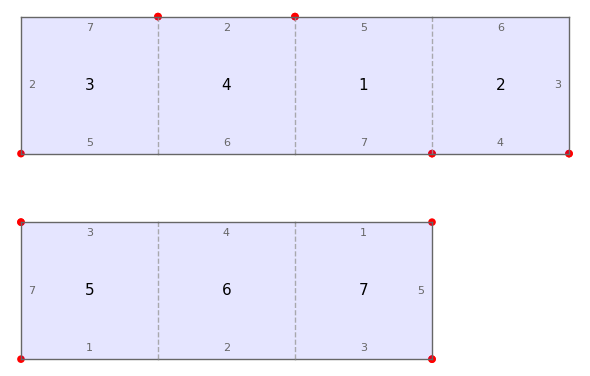

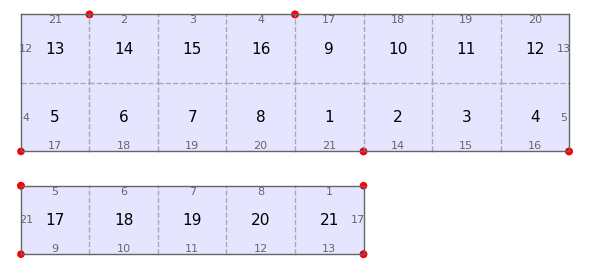

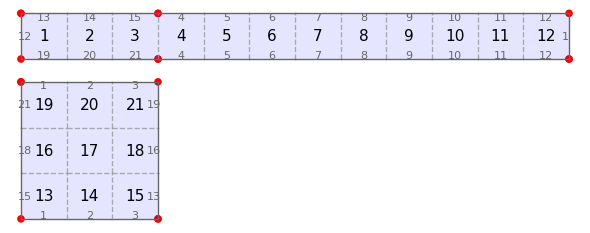

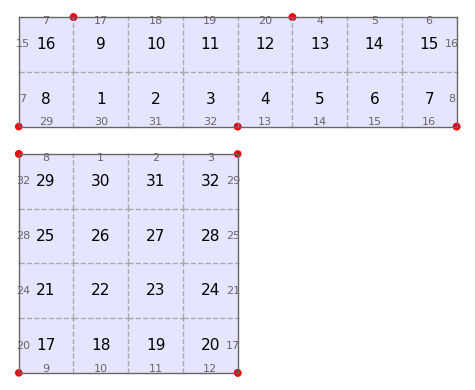

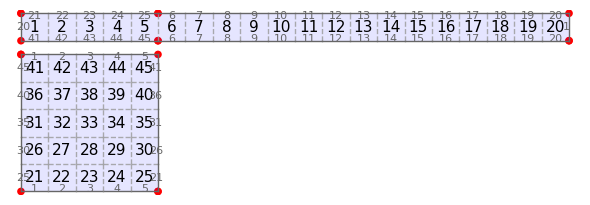

In [22]:
# Origamis in H(2) that should be convex
ori_1 = Origami('(1,2,3,4)(5,6,7)','(1,5,3,7)(2,6,4)')
ori_2 = Origami('(1,2,3,4,5,6,7,8)(9,10,11,12,13,14,15,16)(17,18,19,20,21)','(1,9,17,5,13,21)(2,10,18,6,14)(3,11,19,7,15)(4,12,20,8,16)')
ori_3 = Origami('(1,2,3,4,5,6,7,8,9,10,11,12)(13,14,15)(16,17,18)(19,20,21)',\
                '(1,13,16,19)(2,14,17,20)(3,15,18,21)(4)(5)(6)(7)(8)(9)(10)(11)(12)') # (49,0)
ori_4 = Origami('(1,2,3,4,5,6,7,8)(9,10,11,12,13,14,15,16)(17,18,19,20)(21,22,23,24)(25,26,27,28)(29,30,31,32)',\
                '(1,9,17,21,25,29,8,16,7,15,6,14,5,13,4,12,20,24,28,32,3,11,19,23,27,31,2,10,18,22,26,30)') # 64
ori_5 = Origami('(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20)(21,22,23,24,25)(26,27,28,29,30)(31,32,33,34,35)(36,37,38,39,40)(41,42,43,44,45)',\
                '(1,21,26,31,36,41)(2,22,27,32,37,42)(3,23,28,33,38,43)(4,24,29,34,39,44)(5,25,30,35,40,45)(6)(7)(8)(9)(10)(11)(12)(13)(14)(15)(16)(17)(18)(19)(20)') # (81,0)


print(ori_1.stratum())
print(ori_2.stratum())
print(ori_3.stratum())
print(ori_4.stratum())
print(ori_5.stratum())

ori_1.show()
ori_2.show()
ori_3.show()
ori_4.show()
ori_5.show()

In [11]:
print(Lelievre_Weiss_Test(ori_1))

True


In [21]:
print(Lelievre_Weiss_Test(ori_2))

True


In [12]:
print(Lelievre_Weiss_Test(ori_3))

True


Thought below case should be convex?

In [23]:
print(Lelievre_Weiss_Test(ori_4))

False


In [24]:
print(Lelievre_Weiss_Test(ori_5))

True


In [ ]:
# Origami in H(4) that should be convex
pi_r = '(1,2,3,4,5,6,51,52)' +\
        '(7,8,9,10,11,12,13,14,39,40,41,42,43,44)' +\
        '(15,16,17,18,19,20,21,22,45,46,47,48,49,50)' +\
        '(23,24,25,26,27,28,29,30)' +\
        '(31,32,33,34,35,36,37,38)'
pi_u = '(1,8,16,24,32,39,45,5,12,20,28,36,43,49)' +\
        '(2,9,17,25,33,40,46,6,13,21,29,37,44,50)' +\
        '(3,10,18,26,34,41,47,51)' +\
        '(4,11,19,27,35,42,48,52)' +\
        '(7,15,23,31,14,22,30,38)'
ori_6 = Origami(pi_r,pi_u)
print(ori_6.stratum())
ori_6.show()

In [ ]:
print(Lelievre_Weiss_Test(ori_6))

# Test Cases: Non-Convex

Lelievre-Weiss gives all 7 types of non-strictly-convex origamis in $\mathcal{H}(2)$. These types are classified as:
1. $D=9$, a representative of which is $X(0,2,1,1)$
2. $D=16$, a representative of which is $X(0,3,1,1)$
3. $D=36$, a representative of which is $X(1,4,2,2)$
4. $(D,\epsilon) = (25,0)$, a representative of which is $X(0,6,1,3)$
5. $(D,\epsilon) = (25,1)$, a representative of which is $X(0,6,1,2)$
6. $(D,\epsilon) = (49,1)$, a representative of which is $X(0,12,1,4)$
7. $(D,\epsilon) = (81,1)$, a representative of which is $X(0,20,1,4)$

Here, the notation $X(a,b,c,\lambda)$ denotes the translation surface
<img src="nonconvex.PNG" width="300">

H_2(2)


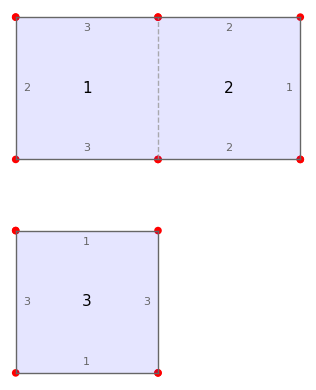

H_2(2)


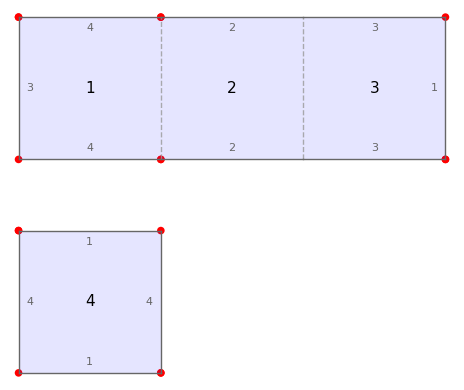

H_2(2)


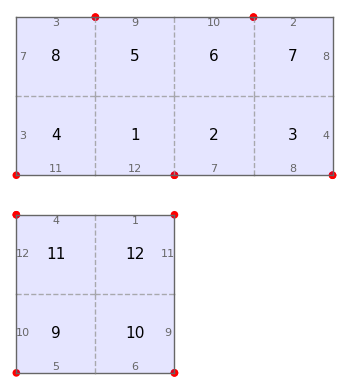

H_2(2)


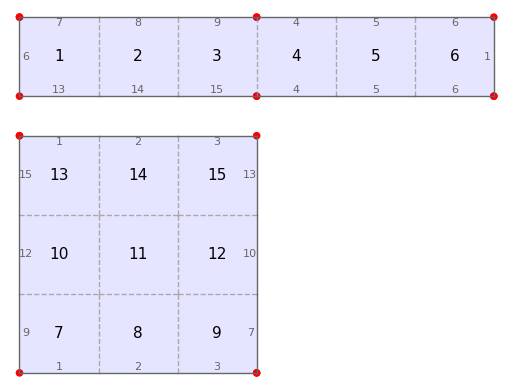

H_2(2)


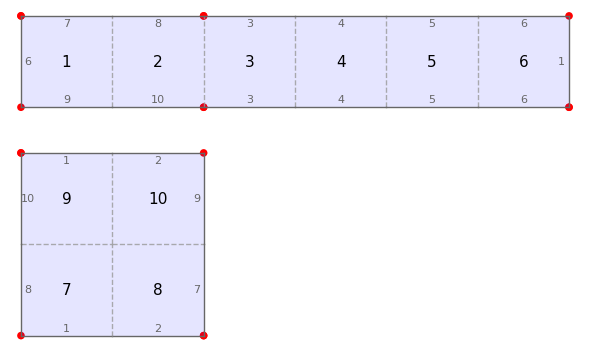

H_2(2)


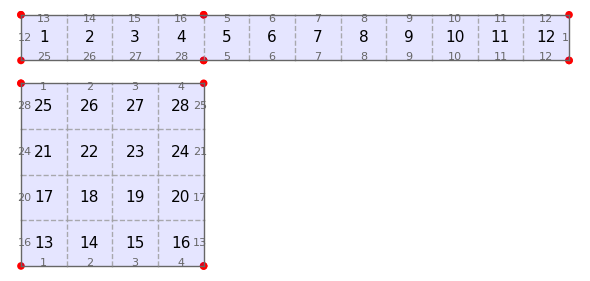

H_2(2)


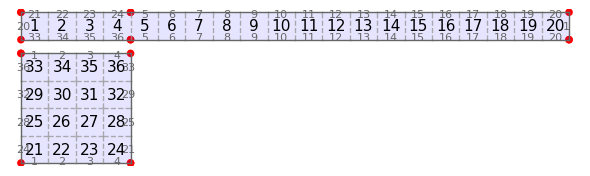

In [13]:
# The 7 representatives described above are initialized below:
ori_1_nc = Origami('(1,2)(3)','(1,3)(2)')
ori_2_nc = Origami('(1,2,3)(4)','(1,4)(2)(3)')
ori_3_nc = Origami('(1,2,3,4)(5,6,7,8)(9,10)(11,12)','(1,5,9,11,4,8,3,7,2,6,10,12)')
ori_4_nc = Origami('(1,2,3,4,5,6)(7,8,9)(10,11,12)(13,14,15)','(1,7,10,13)(2,8,11,14)(3,9,12,15)(4)(5)(6)')
ori_5_nc = Origami('(1,2,3,4,5,6)(7,8)(9,10)','(1,7,9)(2,8,10)(3)(4)(5)(6)')
ori_6_nc = Origami('(1,2,3,4,5,6,7,8,9,10,11,12)(13,14,15,16)(17,18,19,20)(21,22,23,24)(25,26,27,28)',\
                   '(1,13,17,21,25)(2,14,18,22,26)(3,15,19,23,27)(4,16,20,24,28)(5)(6)(7)(8)(9)(10)(11)(12)')
ori_7_nc = Origami('(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20)(21,22,23,24)(25,26,27,28)(29,30,31,32)(33,34,35,36)',\
                   '(1,21,25,29,33)(2,22,26,30,34)(3,23,27,31,35)(4,24,28,32,36)(5)(6)(7)(8)(9)(10)(11)(12)(13)(14)(15)(16)(17)(18)(19)(20)')

ori_ncs = [ori_1_nc,ori_2_nc,ori_3_nc,ori_4_nc,ori_5_nc,ori_6_nc,ori_7_nc]
for ori_nc in ori_ncs:
    print(ori_nc.stratum())
    ori_nc.show()

In [14]:
print(Lelievre_Weiss_Test(ori_1_nc))

False


In [15]:
print(Lelievre_Weiss_Test(ori_2_nc))

False


In [16]:
print(Lelievre_Weiss_Test(ori_3_nc))

False


In [17]:
print(Lelievre_Weiss_Test(ori_4_nc))

False


In [18]:
print(Lelievre_Weiss_Test(ori_5_nc))

False


In [19]:
print(Lelievre_Weiss_Test(ori_6_nc))

False


In [20]:
print(Lelievre_Weiss_Test(ori_7_nc))

False
